# Imports and setting up viz

NB : conda env1 on Mac, lam1env on spirit (Python3.12)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import cartopy.crs as ccrs
import cartopy
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from scipy.stats import ttest_ind
%matplotlib inline

#import personnal tools
from tools import *

/home/ptiengou/.conda/envs/lam1env/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# plt.rcParams.update(
#         {
#             'figure.facecolor': 'white',
#             'axes.facecolor': 'white',
#             'font.size': 12,
#             'figure.dpi': 72.0,
#             'xtick.direction': 'in',
#             'ytick.direction': 'in',
#             'xtick.major.size': 5.0,
#             'xtick.minor.size': 2.5,
#             'ytick.major.size': 5.0,
#             'ytick.minor.size': 2.5,
#             'xtick.minor.visible': True,
#             'ytick.minor.visible': True,
#             'axes.grid': True,
#             'axes.titlesize': 'larger',
#             'axes.labelsize': 'larger',
#             'grid.color': 'dimgray',
#             'grid.linestyle': '-',
#             'grid.alpha': 0.3,
#             'axes.prop_cycle': cycler(
#                 color=[
#                     '#0C5DA5',
#                     '#FF9500',
#                     '#00B945',
#                     '#FF2C00',
#                     '#845B97',
#                     '#474747',
#                     '#9E9E9E',
#                 ]
#             ) * cycler(alpha=[0.8]),
#             'scatter.marker': 'x',
#             'lines.linewidth': 1.0,
#         })

In [3]:
rivers = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor=(0, 0, 0, 0.3), facecolor='none')

# Load and edit files

LAM output analysis.

simu irr et simu no-irr.

## Sims

In [ ]:
noirr_dir='../../../JZ_simu_outputs/LAM/noirr_2010_2022'
irr_dir='../../../JZ_simu_outputs/LAM/irr_2010_2022'

In [ ]:
#open netcdf files for native routing on ORC grid
filename = '{}/SRF/MO/*history.nc'.format(noirr_dir)
ORC0 = xr.open_mfdataset(filename)
#name
ORC0.attrs['name'] = 'no_irr'
#time counter
ORC = ORC0.rename({'time_counter':'time'})
#define vars
ORC['totrunoff'] = ORC['runoff'] + ORC['drainage']
# limit data to lon and lat of interest (-13,6) and (32,49)
# ORC = ORC.sel(lon=slice(-13,6),lat=slice(32,49))
ORC


In [ ]:
filename = '{}/SRF/MO/*history.nc'.format(irr_dir)
ORC0irr = xr.open_mfdataset(filename)
#name
ORC0irr.attrs['name'] = 'irr'
#time counter
ORCirr = ORC0irr.rename({'time_counter':'time'})
#define vars
ORCirr['totrunoff'] = ORCirr['runoff'] + ORCirr['drainage']
# limit data to lon and lat of interest (-13,6) and (32,49)
# ORC = ORC.sel(lon=slice(-13,6),lat=slice(32,49))
ORC0irr

In [ ]:
#sim
filename = '{}/ATM/TS*.nc'.format(noirr_dir)
# filename='/data/ptiengou/JZ_simu_outputs/LAM/noirr_2010_2022/ATM/TS_MO_noirr_precip.nc'
sim0 = xr.open_mfdataset(filename)
sim0.attrs['name'] = 'no_irr'
sim = sim0.rename({'time_counter':'time'})
sim = sim.sel(lon=slice(-13,6),lat=slice(32,49))

sim['evap'] = sim['evap'] *3600 * 24
sim['evap'].attrs['units'] = 'mm/d'
sim['precip'] = sim['precip'] *3600 * 24
sim['precip'].attrs['units'] = 'mm/d'
sim

In [ ]:
#sim irr
filename = '{}/ATM/TS*.nc'.format(irr_dir)
# filename='/data/ptiengou/JZ_simu_outputs/LAM/noirr_2010_2022/ATM/TS_MO_noirr_precip.nc'
sim0irr = xr.open_mfdataset(filename)
sim0irr.attrs['name'] = 'irr'
simirr = sim0irr.rename({'time_counter':'time'})
simirr = simirr.sel(lon=slice(-13,6),lat=slice(32,49))

simirr['evap'] = simirr['evap'] *3600 * 24
simirr['precip'] = simirr['precip'] *3600 * 24
sim0irr


## Obs

In [ ]:
#open ERA5 file
filename = '../../../obs/ERA5_eval_2010_2022.nc'
era = xr.open_mfdataset(filename)
era.attrs['name'] = 'ERA5'
#define or edit vars
#name ERA5 vars like in LMDZOR outputs
dict =  {
        'longitude':'lon',
        'latitude':'lat',
        'e':'evap',
        'ro':'totrunoff',
        'tp':'precip'
        }
era = era.rename(dict)

#make evap positive in era
era['evap'] = -era['evap'] * 1000
era['evap'].attrs['units'] = 'mm'
era['precip'] = era['precip']*1000
era['precip'].attrs['units'] = 'mm'
era


In [ ]:
#gleam
filename='/data/ptiengou/obs/evap/E_1980-2022_GLEAM_v3.8a_MO.nc'
gleam0=xr.open_dataset(filename)
gleam0.attrs['name']='GLEAM'
gleam = gleam0.sel(lon=slice(-13,6),lat=slice(49,32))
#adapt period
gleam=gleam.sel(time=slice('2010-01-01', '2022-12-31'))
#name gleam vars like in LMDZOR outputs
dict =  {
        'E':'evap'
        }
gleam = gleam.rename(dict)
#convert mm/month to mm/day
gleam['evap']=gleam['evap']/30
gleam['evap'].attrs['units']='mm/d'
gleam

In [ ]:
filename='/data/ptiengou/obs/FluxCom/ensemble_rs-_meteo_ALL/monthly/*.RS_METEO.EBC-*.MLM-ALL.METEO-ALL.720_360.monthly.*.nc'
fluxcom0=xr.open_mfdataset(filename)
fluxcom=fluxcom0.sel(lon=slice(-13,6.25),lat=slice(49,32))
fluxcom=fluxcom.sel(time=slice('2010-01-01', '2022-12-31'))

fluxcom.attrs["name"]='FluxCom'

fluxcom['evap'] = fluxcom['LE'] * 0.408 # To convert from MJ/m2/d to mm/d
fluxcom['evap'].attrs['units'] = 'mm/d'

fluxcom['fluxlat'] = fluxcom['LE'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['fluxlat'].attrs['units'] = 'W/m²'

fluxcom['fluxsens'] = fluxcom['H'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['fluxsens'].attrs['units'] = 'W/m²'

fluxcom['netrad'] = fluxcom['Rn'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['netrad'].attrs['units'] = 'W/m²'
fluxcom

In [6]:
#gpcp
filename='../../../obs/precips/precip.mon.total.0.25x0.25.v2020.nc'
gpcp0=xr.open_mfdataset(filename)
gpcp0.attrs['name'] = 'gpcp'
gpcp=gpcp0.sel(time=slice('2010-01-01', '2022-12-31'))
gpcp['lon'] = ((gpcp['lon'] + 180) % 360) - 180
gpcp = gpcp.sortby('lon')

# gpcp=gpcp.sel(lon=slice(-13,6.25),lat=slice(32,49))
gpcp1=gpcp.sel(lon=slice(-13,6.25),lat=slice(49,32))

# gpcp1=gpcp.sel(lon=slice(347,360),lat=slice(49,32))
# gpcp2=gpcp.sel(lon=slice(0,6.25),lat=slice(49,32))
# gpcp=xr.combine_by_coords([gpcp1, gpcp2])
# gpcp = gpcp.where(gpcp['lon'] < 6.25, drop=True)

# gpcp['lon']=gpcp['lon']-180.0
# gpcp=gpcp.sel(lon=slice(-13,6.25))

gpcp1

# Masking and time period selection

In [ ]:
# Select the JJA months (June, July, August)
# ORC = ORC.sel(time=ORC['time.month'].isin([6, 7, 8]))
# ORCnoirr = ORCnoirr.sel(time=ORCnoirr['time.month'].isin([6, 7, 8]))
#sim = sim.sel(time=sim['time.month'].isin([6, 7, 8]))
#sim = sim.sel(time=sim['time.month'].isin([6, 7, 8]))

In [ ]:
#continental fraction mask (LMDZ outputs)
con_mask=sim['contfracATM']>0
#create a masks of data points where irrig_frac >5%
irr_mask = (ORCirr['irrigmap_dyn']/ORCirr['Areas'])>0.05

In [ ]:
contSim=sim.where(con_mask)
contSimirr=simirr.where(con_mask)

In [ ]:
irrORC=ORC.where(irr_mask)
irrORCirr=ORCirr.where(irr_mask)

In [ ]:
# era
intEra=era.interp_like(sim)
contEra=intEra.where(con_mask)

<xarray.Dataset>
Dimensions:    (lon: 77, lat: 69, time: 156)
Coordinates:
  * lon        (lon) float32 -13.0 -12.75 -12.5 -12.25 ... 5.25 5.5 5.75 6.0
  * lat        (lat) float32 49.0 48.75 48.5 48.25 ... 32.75 32.5 32.25 32.0
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
Data variables:
    u10        (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    v10        (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    evap       (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    totrunoff  (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    precip     (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-16 10:03:54 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
    name:         ERA5

In [ ]:
#gleam
intGleam=gleam.interp_like(sim)
contGleam=gleam.interp_like(sim).where(con_mask)
irrEra=era.interp_like(ORC).where(irr_mask)
irrGleam=gleam.interp_like(ORC).where(irr_mask)

<xarray.Dataset>
Dimensions:  (time: 156, lon: 76, lat: 68)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2022-12-31
  * lon      (lon) float64 -12.88 -12.62 -12.38 -12.12 ... 5.375 5.625 5.875
  * lat      (lat) float64 48.88 48.62 48.38 48.12 ... 32.88 32.62 32.38 32.12
Data variables:
    evap     (time, lat, lon) float32 nan nan nan nan ... 0.06059 0.05702 0.0631
Attributes:
    name:     GLEAM

In [ ]:
#fluxcom
intFluxcom=fluxcom.interp_like(sim)
contFluxcom=fluxcom.interp_like(sim).where(con_mask)

<xarray.Dataset>
Dimensions:    (lat: 7, lon: 8, time: 156, nv: 2)
Coordinates:
  * lat        (lat) float32 33.75 36.25 38.75 41.25 43.75 46.25 48.75
  * lon        (lon) float32 -11.25 -8.75 -6.25 -3.75 -1.25 1.25 3.75 6.25
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(156, 2), meta=np.ndarray>
    lat_bnds   (lat, nv) float32 dask.array<chunksize=(7, 2), meta=np.ndarray>
    lon_bnds   (lon, nv) float32 dask.array<chunksize=(8, 2), meta=np.ndarray>
    precip     (time, lat, lon) float32 dask.array<chunksize=(156, 7, 8), meta=np.ndarray>
Attributes: (12/19)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2024/04 through latest.
    name:                  gpcp

In [ ]:
#gpcp
intGpcp=gpcp.interp_like(sim)
contGpcp=gpcp.interp_like(sim).where(con_mask)

# Maps

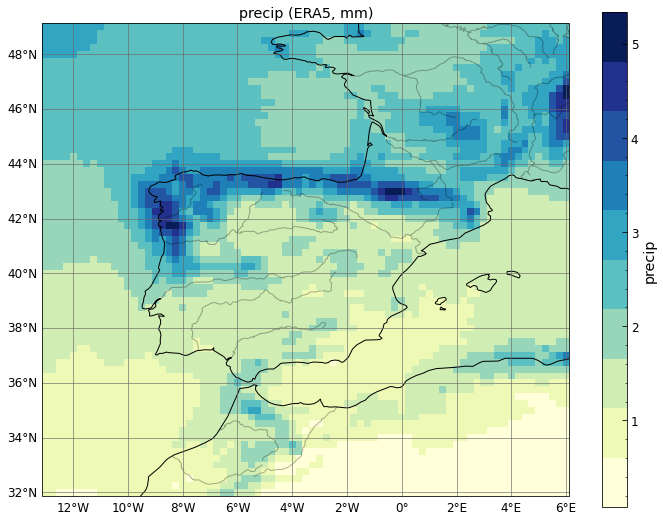

In [7]:
#Display map of var for ds
var='precip'
ds=gpcp1
color_map=wet
max_value=None

map_ave(ds, var, in_cmap=color_map, in_vmax=max_value)

In [ ]:
#Display map of var for ds on restricted area
var='evap'
ds = sim
# ds = std
latmin=36.7
latmax=36.9
lonmin=-6.4
lonmax=-6.2

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True)
ds = ds.where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True)
ds = ds.where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=reds)
plt.title(var + ' (' + ds.name + ')')

In [ ]:
#Diff map
var='evap'
max_value=3
ds1=contSim
ds2=contEra
title = 'Precipitation bias vs ERA5 (mm/day)'
map_diff_ave(ds1, ds2, var, in_vmax=max_value)

Text(0.5, 1.0, 'Precipitation bias vs ERA5 (August mm/day)')

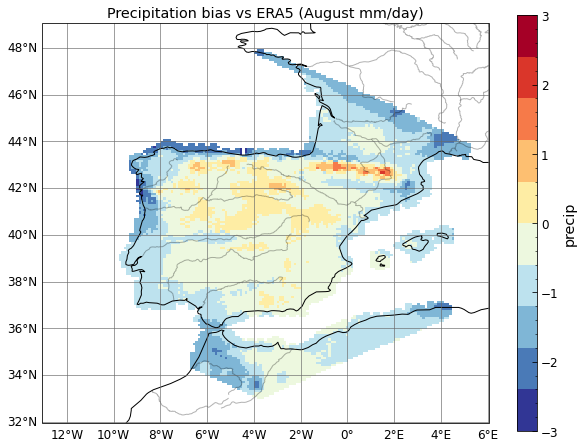

In [ ]:
#Relative diff map
var='sfcWind'
max_value=None
ds1=sim
ds2=sim
# plt.title('Gross primary production relative difference (%)')
map_rel_diff_ave(ds1, ds2, var, in_vmax=max_value)

In [ ]:
# Display 2 maps of var
var = 'evap'
min_value=None
max_value=None
color_map=wet
ds1 = era
ds2 = era
map_two_ds(ds1, ds2, var)

# Time series

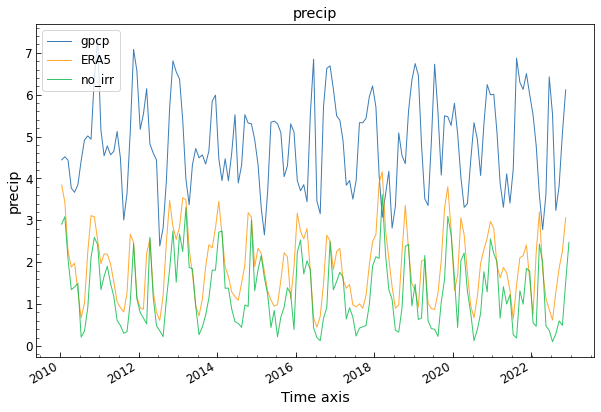

In [ ]:
#Average time series
var='evap'
ds1=contSim
ds2=contSimirr
ds3=contEra
ds4=contGleam
ds5=contFluxcom
ds_list=[ds1, ds2, ds3, ds4, ds5]
year_max=2013
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()

for ds in ds_list:
    ds = ds.where(ds['time.year'] <= year_max, drop=True)
    (ds[var]*1).mean(dim=['lon','lat']).plot(ax=ax, label=ds.name)

plt.title(var)
plt.legend()
ax.set_ylabel('')
ax.set_xlabel('')

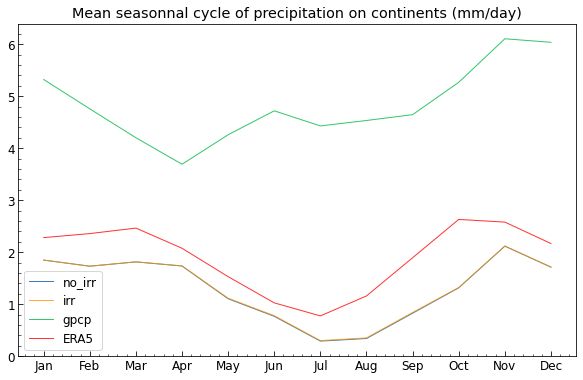

In [ ]:
#Average seasonnal cycle
var='precip'
ds1=contSim
ds2=contSimirr
ds3=contEra
ds4=contGleam
ds5=contFluxcom
ds_list=[ds1, ds2, ds3, ds4, ds5]
year_max=2013
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(bottom=0)

for ds in ds_list:
    ds = ds.where(ds['time.year'] <= year_max, drop=True)
    # ds = ds.where(ds['time.year'] >= year_min, drop=True).where(ds['time.year'] <= year_max, drop=True)
    print(ds.attrs['name'] + ' : ' + str(ds[var].mean(dim=['lon','lat', 'time']).values) + 'mm/d')
    ds[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds.name)

plt.title(var)
plt.title("Mean seasonnal cycle of precipitation on continents (mm/day)")
plt.legend()